# Kuala Lumpur Weather Prediction using FB Prophet and 10 Years Historical Data

In [1]:
#pip install PyQt5==5.13
#pip install PyQtWebEngine==5.13

Name: Hamzah Hamizan

**Project Introduction**

Floods are one of the most destructive natural catastrophes, and can occur as a result of a variety of factors, including prolonged periods of rainfall, urbanisation, poor drainage and sewerage system, changes in land terrain, and so on. The purpose of this capstone project is to investigate the influence of weather on flooding within Kuala Lumpur region. The occurrence of flood in this critical region of Malaysia, which has many Central Business Districts (CBDs), will impede the surrounding businesses as well as the daily lives of those who live and work in the city centre.

This capstone project can be used as a reference for authorities, organisations, and the general public in anticipating floods and recognising the various indicators that can lead to flooding.

As a result, a time-series model powered by FB Prophet was used to make predictions based on historical meteorological data for the past ten years, starting on March 3, 2012, to determine the likelihood of flooding. The notion is reinforced even further by the inclusion of urbanization mapping via Google Earth Engine, which visualises the city's growth over the last 36 years which could also be a factor in the natural disaster's occurrence.

## Install and Import Dependencies

In [2]:
import pandas as pd
import numpy as np
import chart_studio.plotly as plotly
import plotly.figure_factory as ff
from plotly import graph_objs as go
from matplotlib import pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import pystan
import pickle
import geemap
from IPython.display import HTML

## Read in Data and Process Dataset

#### Defining the dataset

In [3]:
old_df = pd.read_csv('Kuala+Lumpur.csv')
old_df.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2012-03-08,32,22,0.0,8.8,6,98,07:20 PM,06:54 AM,07:22 AM,...,7,44,80,4.1,1006,32,10,192,5,Kuala+Lumpur
1,2012-03-09,33,22,0.0,11.6,6,91,08:14 PM,07:45 AM,07:22 AM,...,8,45,75,4.1,1006,33,9,272,6,Kuala+Lumpur
2,2012-03-10,32,22,0.0,10.2,6,84,09:10 PM,08:36 AM,07:21 AM,...,6,59,81,6.3,1007,32,9,270,4,Kuala+Lumpur
3,2012-03-11,31,23,0.0,6.0,6,77,10:07 PM,09:31 AM,07:21 AM,...,7,61,86,8.3,1008,31,8,97,4,Kuala+Lumpur
4,2012-03-12,26,22,0.0,7.4,5,71,11:06 PM,10:27 AM,07:21 AM,...,9,74,94,5.0,1010,26,6,45,6,Kuala+Lumpur


#### Check for data types and any null values

As data tends to be cluttered with insignificant values, inaccurate predictions are possible when the values are not removed / replaced. Although there are various approaches to manage this issue, the NULL and missing values will be dropped in this project because it is the quickest and easiest way to handle, if any NULL values exist. To guarantee that the quality of the datasets is not compromised due to the lower sample size, it is still desirable that the data be paired with the proper value, or forecasted using a ML Algorithm.

In [4]:
old_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_time          3653 non-null   object 
 1   maxtempC           3653 non-null   int64  
 2   mintempC           3653 non-null   int64  
 3   totalSnow_cm       3653 non-null   float64
 4   sunHour            3653 non-null   float64
 5   uvIndex            3653 non-null   int64  
 6   moon_illumination  3653 non-null   int64  
 7   moonrise           3653 non-null   object 
 8   moonset            3653 non-null   object 
 9   sunrise            3653 non-null   object 
 10  sunset             3653 non-null   object 
 11  DewPointC          3653 non-null   int64  
 12  FeelsLikeC         3653 non-null   int64  
 13  HeatIndexC         3653 non-null   int64  
 14  WindChillC         3653 non-null   int64  
 15  WindGustKmph       3653 non-null   int64  
 16  cloudcover         3653 

In [5]:
# Handle Missing Values
old_df.isnull().sum()*100/len(old_df)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


date_time            0.0
maxtempC             0.0
mintempC             0.0
totalSnow_cm         0.0
sunHour              0.0
uvIndex              0.0
moon_illumination    0.0
moonrise             0.0
moonset              0.0
sunrise              0.0
sunset               0.0
DewPointC            0.0
FeelsLikeC           0.0
HeatIndexC           0.0
WindChillC           0.0
WindGustKmph         0.0
cloudcover           0.0
humidity             0.0
precipMM             0.0
pressure             0.0
tempC                0.0
visibility           0.0
winddirDegree        0.0
windspeedKmph        0.0
location             0.0
dtype: float64

It is observed that the values are all in place when the ".isnull().sum()" is equivalent to 0.0.

#### Drop unused columns

It is very unlikely that Kuala Lumpur to experience any form of snow formation, hence the "totalSnow_cm" column is dropped from the dataframe

In [6]:
df = old_df.drop(['totalSnow_cm'], axis = 1)

#### Identifying the scale of measurement used

In [7]:
numerical_feature = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 18
Discrete feature Count 13
Continuous feature Count 5
Categorical feature Count 6


In [8]:
print(numerical_feature)

['maxtempC', 'mintempC', 'sunHour', 'uvIndex', 'moon_illumination', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph']


### Correlation between data

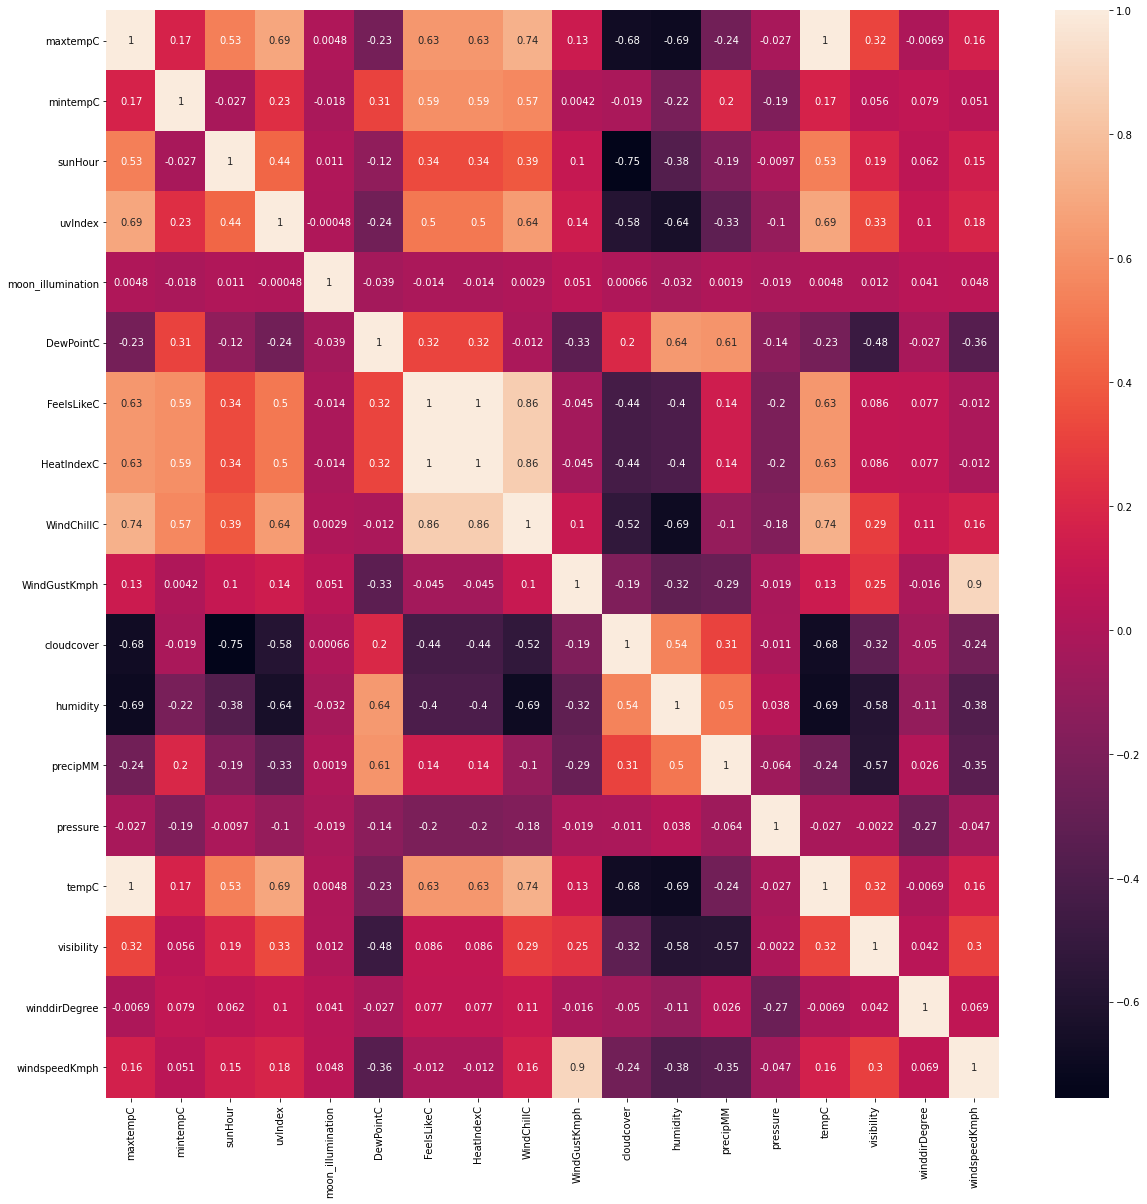

In [9]:
corrmat = df.corr(method = "spearman")
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

Several variables, including WindChillC, FeelsLikeC, and HeatIndexC, uvIndex and tempC, and WindGustKmph and windspeedKmph, have a significant positive correlation. In general, a pearson correlation of more than 0.7 indicates that there is a presence of multi-collinearity.

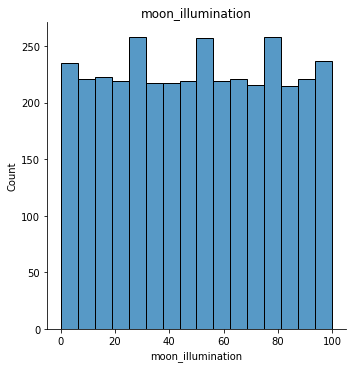

<Figure size 1080x1080 with 0 Axes>

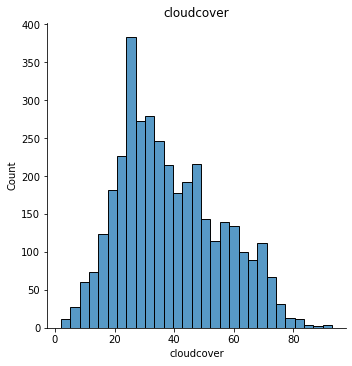

<Figure size 1080x1080 with 0 Axes>

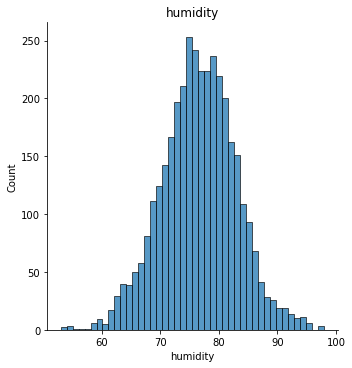

<Figure size 1080x1080 with 0 Axes>

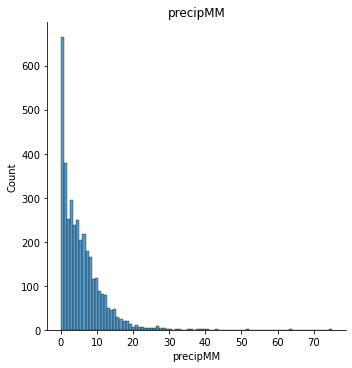

<Figure size 1080x1080 with 0 Axes>

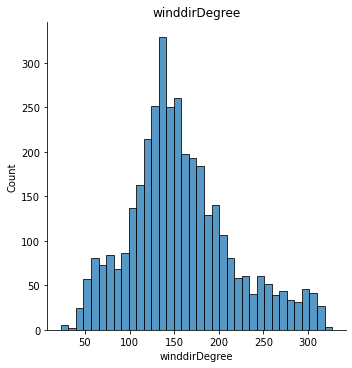

<Figure size 1080x1080 with 0 Axes>

In [10]:
for feature in continuous_feature:
    data=df.copy()
    sns.displot(df[feature])
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.figure(figsize=(15,15))
    plt.show()

The humidity in Kuala Lumpur peaks between 70 and 80 percent, indicating that the area is highly humid, maybe due to the quantity of precipitation it receives on a regular basis, despite the volume of precipitation usually staying between 0 and 10 MM.

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-p

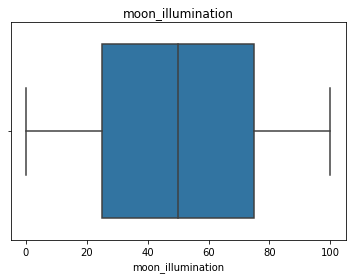

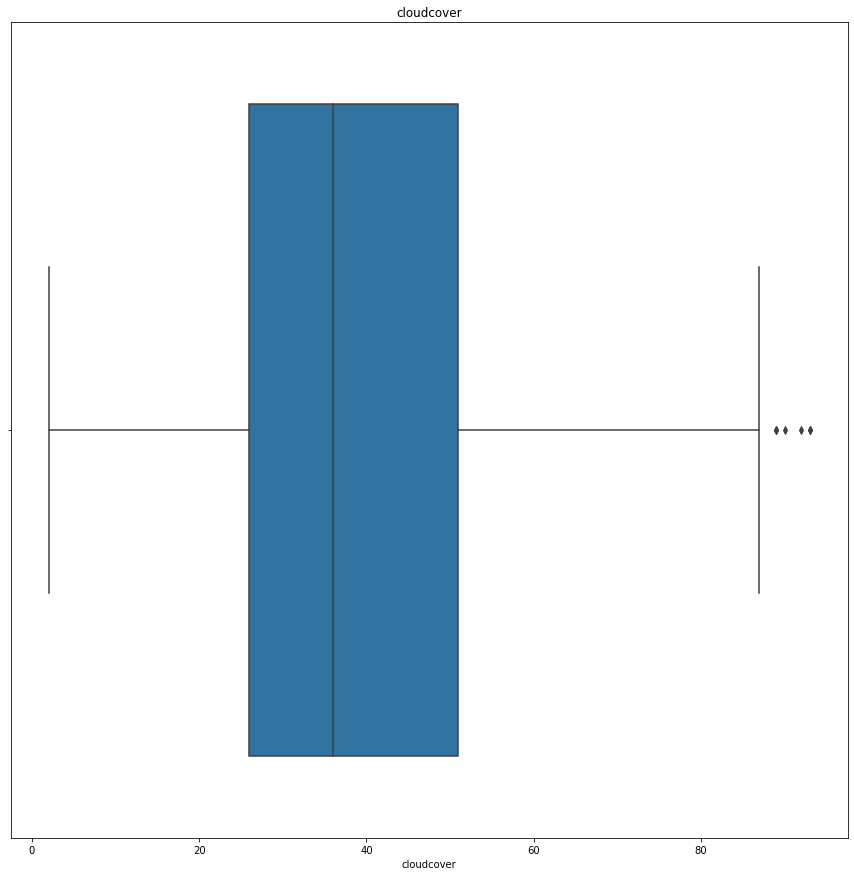

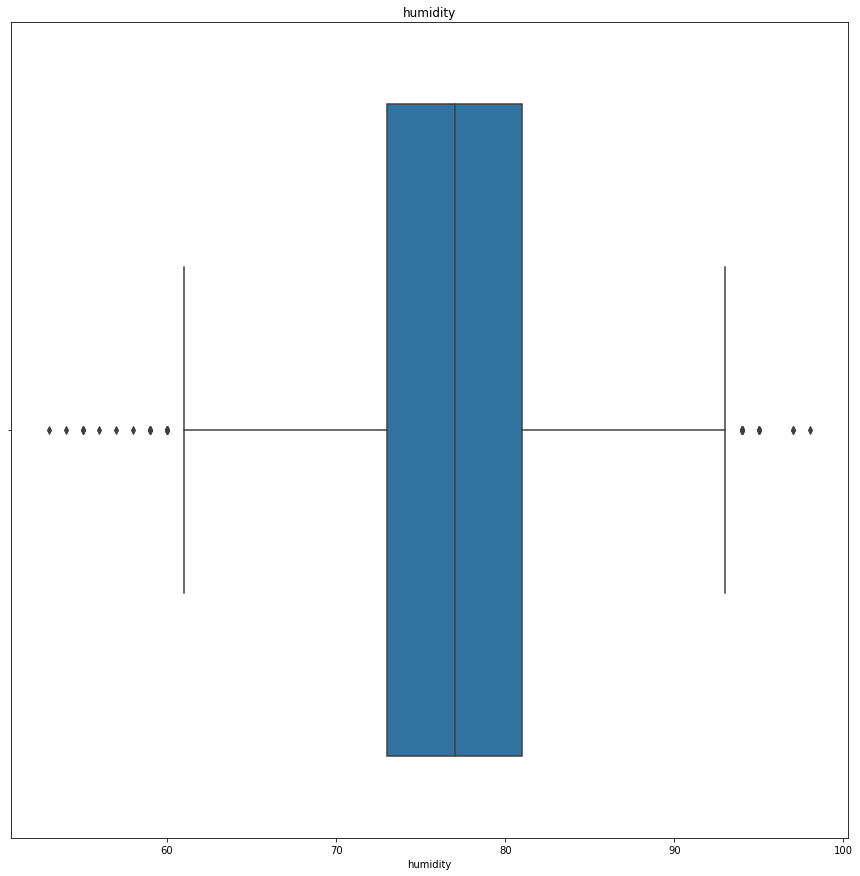

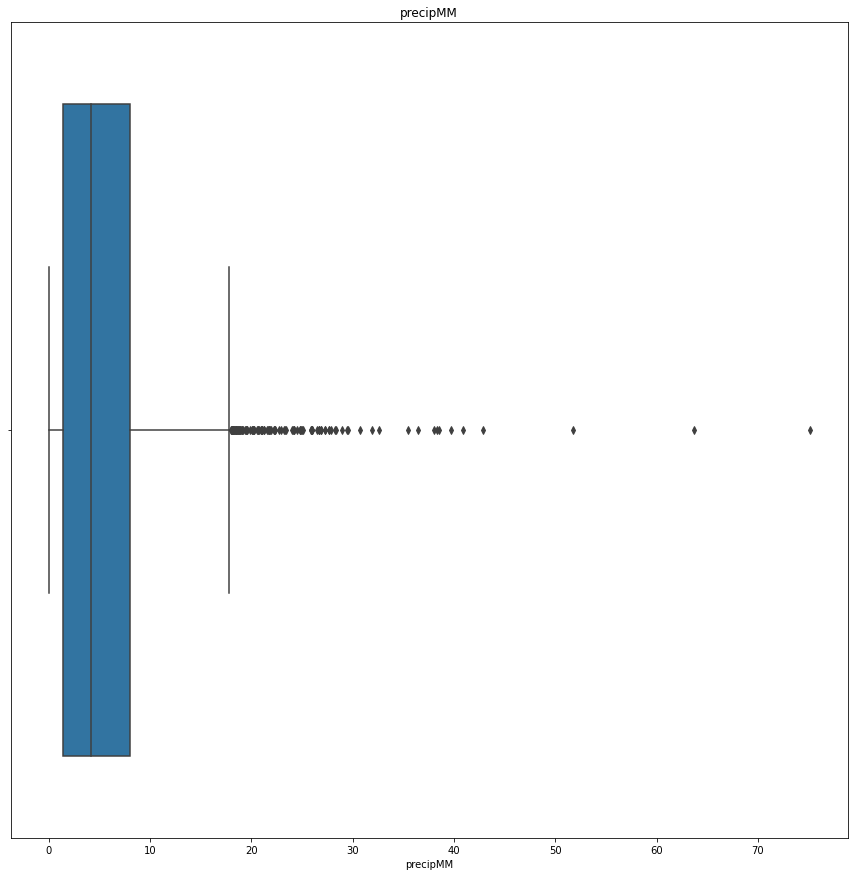

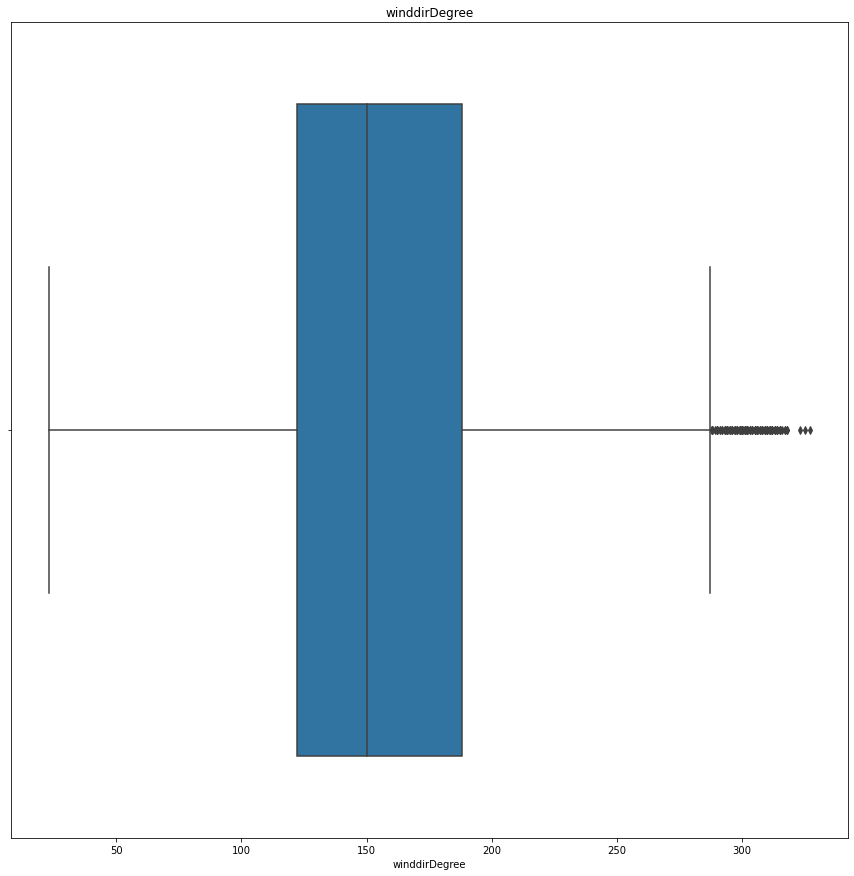

<Figure size 1080x1080 with 0 Axes>

In [11]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

On a normal occasion, we will either remove the outlier or use standard deviation to standardize the data. Since we are dealing with weather data there will be times when the precipitation and humidity are at their greatest, and vice versa. As a result, the values will be retained in order to aid forecasting.

Sincee the data is veryedictable, it's understandable that the average temperature and precipitation would be at their highest or lowest points, given how weather is greatly influenced by seasonal variations (especially during monsoon).

## Looking at temperature data for the past 10 years

#### Preparing the average temperature (temp) vs time (date_time) dataset

The data from the average temperature is compared with the daily period of time to construct a 10-year daily average temperature graph in this section of the analysis. The trend, seasonal cycles, and "outliers" can all be identified by plotting a time-series graph.

In [12]:
fig_temp = go.Figure()
fig_temp.add_trace(go.Scatter(x=df.date_time, y=df['tempC'], name='Average Temperature',line_color='green'))
fig_temp.layout.update(title_text='Time Series of Average Temperature with Rangeslider',xaxis_rangeslider_visible=True)

Layout({
    'template': '...',
    'title': {'text': 'Time Series of Average Temperature with Rangeslider'},
    'xaxis': {'rangeslider': {'visible': True}}
})

In [13]:
fig_temp.show(renderer="browser")

The temperature trend over time, as well as the monthly and yearly seasonal patterns based on the temperature, can be seen by moving the slider. The historical data is crucial in ensuring that the deployed model have a good output.

In [14]:
X = df[['date_time', 'maxtempC']]
y = df.iloc[:,1]

In [15]:
train_df = pd.DataFrame()
train_df['ds'] = pd.to_datetime(X['date_time'])
train_df['y']=y

In [16]:
train_df.head(10)

,ds,y
0,2012-03-08,32
1,2012-03-09,33
2,2012-03-10,32
3,2012-03-11,31
4,2012-03-12,26
5,2012-03-13,32
6,2012-03-14,34
7,2012-03-15,33
8,2012-03-16,36
9,2012-03-17,33


#### Training the model

The model is trained for a period of 365 days (1 year) from the latest data input given.

In [17]:
model = Prophet()
model.fit(train_df)
future_temp = model.make_future_dataframe(periods=365)
future_temp.tail(2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
4016,2023-03-07
4017,2023-03-08


#### Saving and loading the model for future use

In [18]:
with open('saved_model_temp.pkl', "wb") as f:
    pickle.dump(model, f)

In [19]:
with open('saved_model_temp.pkl', "rb") as f:
    m_temp = pickle.load(f)

#### Rendering and viewing the forecast

In [20]:
forecast_temp = m_temp.predict(future_temp)
fig_temp = plot_plotly(m_temp, forecast_temp)

In [21]:
fig_temp.show(renderer="browser")

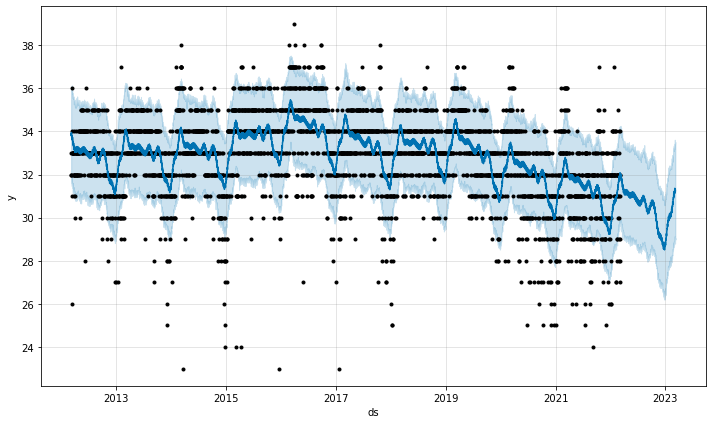

In [22]:
# To render the forecasted graph on jupyter
plot_temp = m_temp.plot(forecast_temp)

Looking at the one-year forecasted temperature graph from March 9, 2022 onwards, it can be seen that the average temperature is much lower than in previous years, but the monthly and daily temperature fluctuates similarly when compared month-to-month or day-to-day, indicating that the temperature's trend has some common characteristics.

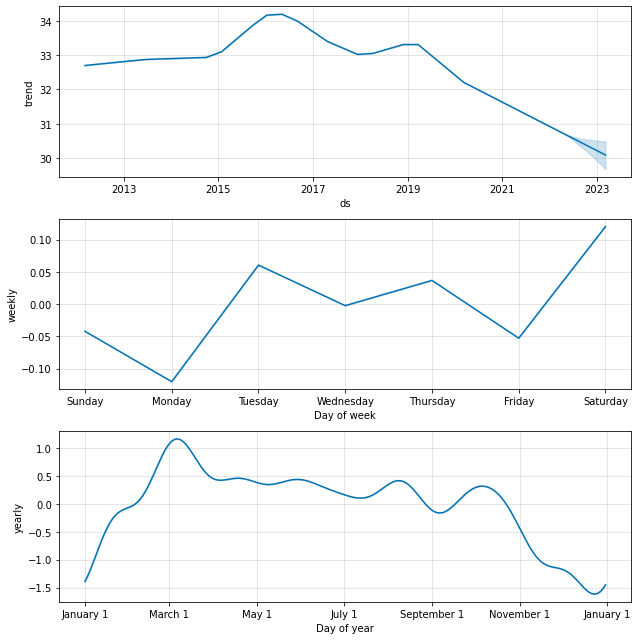

In [23]:
#plot component wise forecast
fig2_temp = m_temp.plot_components(forecast_temp)

Based on the forecast graph shown above, it can be determined that the average daily temperature is on the decline, while the weekly plot shows that the temperature in Kuala Lumpur is at its maximum on weekends. Moving to the yearly plot, it can be seen that the temperature has been trending downward since March 1, maybe due to the heavy rains that have occurred during the last few months.

## Looking at precipitation data over the 10 years

#### Preparing the precipitation (precipMM) vs time (date_time) dataset

The data from daily precipitation is compared with the date to construct a 10-year daily precipitation graph, similar to the previous analysis.

In [24]:
fig_precip = go.Figure()
fig_precip.add_trace(go.Scatter(x=df.date_time, y=df['precipMM'], name='Precipitation in MM',line_color='green'))
fig_precip.layout.update(title_text='Time Series of Daily Precipitation with Rangeslider',xaxis_rangeslider_visible=True)

Layout({
    'template': '...',
    'title': {'text': 'Time Series of Daily Precipitation with Rangeslider'},
    'xaxis': {'rangeslider': {'visible': True}}
})

In [25]:
fig_precip.show(renderer="browser")

It is worth noting that, according to the observation done on the Time Series of Daily Precipitation with Rangeslider that there are a couple of spikes, on April 24, 2020 and April 28, 2021. Based on a simple search online, it can be seen that there were floods happening around the aforementioned dates, namely the [16 April 2020 Flash Flood](https://www.bharian.com.my/berita/kes/2020/04/678066/lebih-20-kenderaan-ditenggelami-banjir-kilat) and the [Heavy Rain and Flash Flood in KL in April 2021](https://www.bharian.com.my/berita/nasional/2021/04/806827/ribut-petir-di-kl-hingga-sabtu) respectively.

In [26]:
X1 = df[['date_time', 'precipMM']]
y1 = df.iloc[:,17]

In [27]:
train_df1 = pd.DataFrame()
train_df1['ds'] = pd.to_datetime(X1['date_time'])
train_df1['y']=y1

In [28]:
train_df1.head(10)

,ds,y
0,2012-03-08,4.1
1,2012-03-09,4.1
2,2012-03-10,6.3
3,2012-03-11,8.3
4,2012-03-12,5.0
5,2012-03-13,1.1
6,2012-03-14,2.1
7,2012-03-15,4.2
8,2012-03-16,3.9
9,2012-03-17,6.7


#### Training the model

The model is trained for a period of 365 days (1 year) from the latest data input given.

In [29]:
model = Prophet()
model.fit(train_df1)
future_prec = model.make_future_dataframe(periods=365)
future_prec.tail(2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
4016,2023-03-07
4017,2023-03-08


In [30]:
with open('saved_model_prec.pkl', "wb") as f:
    pickle.dump(model, f)

In [31]:
with open('saved_model_prec.pkl', "rb") as f:
    m_prec = pickle.load(f)

#### Rendering and viewing the forecast

In [32]:
forecast_prec = m_prec.predict(future_prec)
fig_prec = plot_plotly(m_prec, forecast_prec)

In [33]:
fig_prec.show(renderer="browser")

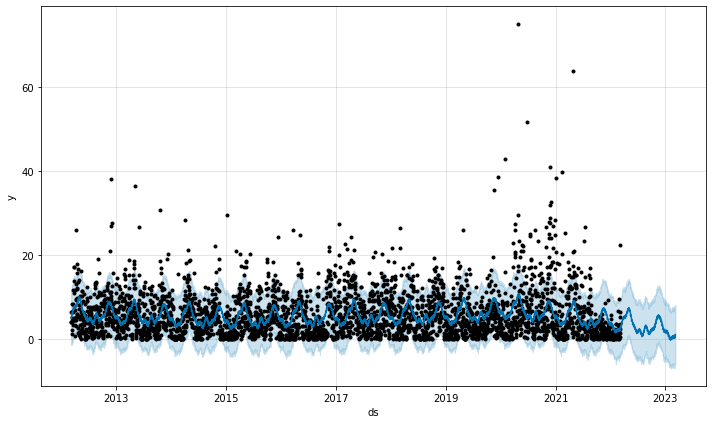

In [34]:
plot_prec = m_prec.plot(forecast_prec)

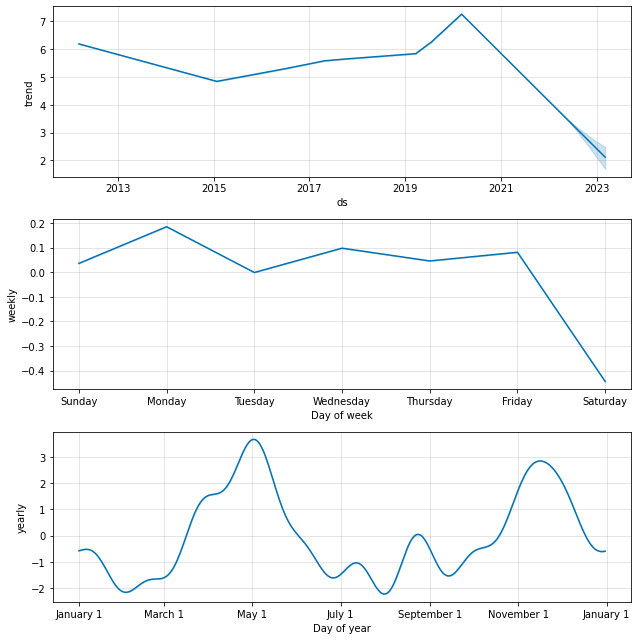

In [35]:
#plot component wise forecast
fig2_prec = m_prec.plot_components(forecast_prec)

We can see a dramatic reduction in precipitation in the years leading up to 2023, possibly due to lower rainfalls. Saturdays have less precipitation, whereas the months of April and June, as well as November and January, have the most precipitation.

These measurements line up with the temperature forecast graph, indicating that temperature and precipitation are inversely connected.

## Observations and comparisons

### Comparing average temperature and precipitation from 19 December 2021 to 7 March 2022

When comparing daily precipitation and average temperature from the flood on [December 19, 2021](https://www.channelnewsasia.com/asia/malaysia-flood-deaths-selangor-pahang-over-people-displaced-2390856), to the recent flood on [March 7, 2022](https://www.thestar.com.my/news/nation/2022/03/07/floods-several-parts-of-kl-submerged-after-continuous-downpour-on-monday-march-7), it can be seen that there are several interesting indicators, including the **decrease in average temperature from the moment the nonstop rain began**, to the **increasing amount of daily precipitation before the flood**.

![PredictionPrec](https://i.ibb.co/C0nK0r1/Slide1.png)

![TimeSeries2](https://i.ibb.co/DDgpwc2/Slide3.png)

### Comparing average temperature and precipitation (Forecasted for 2023)

Now that the predicting has been completed (for a period of one year beginning on March 8, 2022), it can be seen that from **November 2022 to March 2023**, the **average temperature drops to its lowest point in the year**, while **precipitation climbs slightly - likely indicating constant rain**.

Although it is not the only indicator of flash floods, it is best to be **prepared throughout the five months** period to avoid or minimize the impact of rain or probable flooding.

![Prediction2](https://i.ibb.co/nD4GcqR/Slide2.png)

![Prediction1](https://i.ibb.co/2k2cW3h/Slide4.png)

### Relating Kuala Lumpur's high rate of urbanization from 1984 to 2020 to flash floods

By utilizing Google Earth Engine, an animated satellite images of Kuala Lumpur from 1984 to 2020 can be generated, hence making it easier to visualize the level of urbanization of the city.

In [36]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [37]:
label = 'Urban Growth in Kuala Lumpur'
Map.add_landsat_ts_gif(label=label, start_year=1986, bands=['Red','Green','Blue'], font_color='white', frames_per_second=5, progress_bar_color='blue')

Generating URL...
Please wait ...
The GIF image has been saved to: C:\Users\User\AppData\Local\Temp\5f5dde13-e245-4d94-9708-3828b6ea2bf8.gif
ffmpeg is not installed on your computer.
Adding GIF to the map ...
The timelapse has been added to the map.


![myfile](https://storage.googleapis.com/earthengine-timelapse/2020/curated/gifs/kuala-lumpur-malaysia.gif)

### Kuala Lumpur flood location in the past six (6) months
Right-click and Open image in new tab for better quality

![KLFlood](https://i.ibb.co/XfQ90Tz/Map-Data-Final-3x.jpg)

The timelapse video shows how Kuala Lumpur has developed enormously over the last 36 years, not only in terms of architecture but also in terms of its land utilization.

According to statistics from the past six months on flood locations as seen in the diagram above, three of the locations have been flooded twice, and six locations have recently been flooded. It's also worth noting that the majority of Kuala Lumpur's periodic floods occurred in the northern and north-eastern parts of the city, however the recent floods have moved to the southern half of the city.

This is concerning, given that the floods happened within a timeframe of less than 6 months.

## Conclusion

### Project

Precipitation and weather are not the only factors that have contributed to the various floods that have occurred in Kuala Lumpur this year. Other potential variables include the rate of urbanisation, which affects the availability of proper sewage and drainage systems, as well as the accumulation of waste, which may have clogged water exit routes, resulting in flash floods. Poor city design could also have an impact, as having closely spaced buildings next to each other lowers the number of paths via which water can travel.

Based on the pattern developed from 10 years of historical data, the months of November 2022 to March 2023 have the highest likelihood of another continuous rainfall, as indicated in the forecasted graphs. This could potential result in a sequence of flash floods in Kuala Lumpur, but as previously stated, by examining other relevant causes on top of the weather data, the damage done can be kept to a minimum or even prevented.

### Application

The information gathered for this research can be applied to a variety of situations, including:

- To aid in flood prediction based on rainfall and weather, by comparing the real precipitation and meteorological data (from March 9, 2022 onwards) to forecast data from the model

- Using predicted data as a baseline, identifying a variety of likely flood causes

- Better preparation towards heavy / non-stop rain by looking at forecasted low temperature and high precipitation zone (standby zones)

- To serve as a baseline research for developing a data-driven flood-prevention policy in Kuala Lumpur and other parts of the region

Still, additional effort is needed to improve the current project, as well as more implementations to improve the accuracy and usage of model in the near future

### Future works

These are some of the approaches that can be considered to be adopted in order to increase the quality and performance of the data, as well as to better utilize the data:

- Train the data set with >10 years worth of data
- Running other Neural Network algorithm such as LSTM flood forecasting to give a better understanding and better overall output when compared with FB Prophet
- Utilizing GIS data to have a visualized map of the flood areas, to be compared with the urbanization rate of Kuala Lumpr
- To expand the project area to other flood prone region such as Kelantan, Terengganu, Sabah and Sarawak while identifying the other factors that led to flood in each states (eg. Logging rate, River-size reduction)
- Scrape social media channels and news sites to identify the earliest recorded post that included flood within the certain region